---

## **1. Data Preprocessing**

### Load and Normalize Data


In [14]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('csv/data_cleaned.csv')
display(data.head())

# Calculate elapsed days
data['EllapsedDays'] = (datetime.now() - pd.to_datetime(data['Date'])).dt.days
display(data.head())

# Drop unnecessary columns
columns_to_drop = ['DATEADDED', 'ActionGeo_FullName', 'ActionGeo_Lat', 'ActionGeo_Long', 'Lag', 'LagCluster', 'Month']
data.drop(columns=columns_to_drop, inplace=True)
display(data.head())


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month,EllapsedDays
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,3
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,3
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,3
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,3
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,3


,GlobalEventID,Date,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,EllapsedDays
0,1218008600,2024-12-29,1,111,111,11,-2.0,3,6.336634,3
1,1218059434,2024-12-29,1,90,90,9,-2.0,10,-6.250000,3
2,1217968727,2024-12-29,1,111,111,11,-2.0,4,0.806952,3
3,1218064446,2024-12-29,1,90,90,9,-2.0,10,0.884956,3
4,1218009043,2024-12-29,1,111,111,11,-2.0,3,6.336634,3



---

## **2. Data Preparation**

### Prepare Unique Event Codes and Rolling Sequences


In [15]:

# Convert 'Date' to datetime and find min/max dates
data['Date'] = pd.to_datetime(data['Date'])
min_date = data['Date'].min().date()
max_date = datetime.now().date()

print(f"Minimum date in the dataset: {min_date}")
print(f"Maximum date (today): {max_date}")

# Prepare unique event codes
unique_event_base_codes = sorted(data['EventBaseCode'].unique())
base_code_to_index = {code: idx for idx, code in enumerate(unique_event_base_codes)}
print(base_code_to_index)

# Create event count DataFrame
event_count_df = pd.DataFrame(columns=['Date'] + unique_event_base_codes)
event_count_df['Date'] = pd.date_range(start=min_date, end=max_date)

# Fill event counts
for date in event_count_df['Date']:
    day_data = data[data['Date'].dt.date == date.date()]
    for code in unique_event_base_codes:
        event_count_df.loc[event_count_df['Date'] == date, code] = day_data[day_data['EventBaseCode'] == code].shape[0]

# Fill NaN with 0
event_count_df.fillna(0, inplace=True)

# Display prepared DataFrame
display(event_count_df.head())


Minimum date in the dataset: 2020-01-02
Maximum date (today): 2025-01-01
{24: 0, 25: 1, 90: 2, 91: 3, 92: 4, 93: 5, 94: 6, 104: 7, 105: 8, 111: 9, 113: 10, 114: 11, 123: 12, 124: 13, 133: 14, 138: 15, 139: 16, 141: 17, 143: 18, 144: 19, 145: 20, 172: 21, 175: 22, 182: 23, 183: 24}


,Date,24,25,90,91,92,93,94,104,105,...,138,139,141,143,144,145,172,175,182,183
0,2020-01-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-05,0,0,6,0,0,0,0,0,0,...,0,0,5,2,0,0,0,0,0,0
4,2020-01-06,0,0,8,0,0,0,0,0,0,...,0,0,7,2,0,0,0,0,1,0


---

### Create TensorFlow Dataset



In [16]:
# Drop the 'Date' column
event_count_df.drop(columns=['Date'], inplace=True)

# Display the updated DataFrame
display(event_count_df.head())

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0


In [17]:
# Define rolling sequence length
sequence_length = 7

# Extract data and labels
event_data = event_count_df.values.astype('float32')  # All event counts
labels = event_count_df[145].values.astype('float32')  # Predict '145' event counts

# Create TensorFlow datasets
X_dataset = tf.data.Dataset.from_tensor_slices(event_data)
Y_dataset = tf.data.Dataset.from_tensor_slices(labels)

# Create rolling windows
X_sequences = X_dataset.window(sequence_length, shift=1, drop_remainder=True)
X_sequences = X_sequences.flat_map(lambda window: window.batch(sequence_length))
Y_labels = Y_dataset.skip(sequence_length)



In [18]:
# Combine features and labels
dataset = tf.data.Dataset.zip((X_sequences, Y_labels))

In [19]:
# Extract the first sequence and label from the dataset
for x_seq, y_label in dataset.take(1):
	first_x_seq = x_seq
	first_y_label = y_label

# Convert x_seq to a DataFrame
x_df = pd.DataFrame(first_x_seq.numpy(), columns=unique_event_base_codes)
display(x_df)

# Print y_label
print(f"Value of column 145 on the 8th row: {first_y_label.numpy()}")

2025-01-01 09:35:10.365599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,...,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Value of column 145 on the 8th row: 1.0


---

Compared to the following -- the example below is a correct formulation.

---

In [20]:
# Display the first 7 rows of event_count_df
first_7_rows_df = event_count_df.head(7)
display(first_7_rows_df)

# Get the value of column 145 on the 8th row
value_8th_row_col_145 = event_count_df.iloc[7][145]
print(f"Value of column 145 on the 8th row: {value_8th_row_col_145}")

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0
5,0,0,11,0,0,0,0,0,0,21,...,0,0,3,0,0,0,0,0,0,0
6,0,0,22,0,0,0,0,0,0,12,...,4,0,6,0,1,0,0,0,0,0


Value of column 145 on the 8th row: 1


---

Ok good - the values look accurate!

That's fantastic. 

Let's go ahead and do the test / train split.

---

In [21]:

# Split into train/test sets (50/50 split)
split_index = len(event_data) // 2
train_dataset = dataset.take(split_index).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(split_index).batch(32).prefetch(tf.data.AUTOTUNE)




---

## **3. Model Building and Training**

### Build LSTM Model


In [22]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(unique_event_base_codes))),
    #Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks
)


/opt/anaconda3/envs/civil_unrest/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,251 (59.57 KB)

 Trainable params: 15,251 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-01 09:35:10.629411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


     29/Unknown 2s 43ms/step - loss: 95.4347 - mae: 3.7442

2025-01-01 09:35:12.426442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:12.426507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/dropout_1_1/FloorMod/_64]]
2025-01-01 09:35:12.426518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16575873468783419950
2025-01-01 09:35:12.426523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:12.426526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:12.426530: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cance

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 94.2443 - mae: 3.7240 - val_loss: 6.7476 - val_mae: 1.3264
Epoch 2/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.7775 - mae: 1.6200

2025-01-01 09:35:12.998579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:12.998599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9951719058815834150
2025-01-01 09:35:12.998607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2025-01-01 09:35:12.998624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:12.998636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:12.998643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 67.6948 - mae: 2.8896

2025-01-01 09:35:14.161976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:14.161999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:14.162004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:14.162007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_48]]
2025-01-01 09:35:14.162022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8656720440867793302
2025-01-01 09:35:14.162037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 147268733973

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 66.8217 - mae: 2.8689 - val_loss: 6.2453 - val_mae: 1.1214
Epoch 3/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0670 - mae: 1.1859

2025-01-01 09:35:14.517585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:14.517601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:14.517619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:14.517625: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 996930178933625665
2025-01-01 09:35:14.517630: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:14.517641: I tensorflow/core/f

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 63.1603 - mae: 2.7901

2025-01-01 09:35:15.680615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/dropout_1_1/Add/_58]]
2025-01-01 09:35:15.680646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:15.680677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16575873468783419950
2025-01-01 09:35:15.680684: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7972999870250296139
2025-01-01 09:35:15.680689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:15.680701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled.

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 62.3562 - mae: 2.7688 - val_loss: 4.4580 - val_mae: 0.8959
Epoch 4/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.2126 - mae: 0.8585

2025-01-01 09:35:16.022868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:16.022884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:16.022889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/TensorArrayUnstack/TensorListFromTensor/_22]]
2025-01-01 09:35:16.022895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:16.022899: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 996930178933625665
2025-01-01 09:35:16.022903: I tensorflow/core/framework/local_rendezvous.cc:422] Local r

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 52.7946 - mae: 2.4527

2025-01-01 09:35:17.183971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:17.183992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-01-01 09:35:17.184026: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10041515408139760358
2025-01-01 09:35:17.184049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:17.184060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18208430096827273968
2025-01-01 09:35:17.184070: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3626408571701146628
2025-01

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 52.1395 - mae: 2.4387 - val_loss: 3.6352 - val_mae: 0.8608
Epoch 5/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.1635 - mae: 1.1352

2025-01-01 09:35:17.522852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:17.522868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:17.522874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/TensorArrayUnstack/TensorListFromTensor/_22]]
2025-01-01 09:35:17.522879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:17.522883: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9802898297760868701
2025-01-01 09:35:17.522887: I tensorflow/core/framework/local_rendezvous.cc:422] Local 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 40.6797 - mae: 2.3408

2025-01-01 09:35:18.683658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:18.683676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18121488774525001858
2025-01-01 09:35:18.683685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10041515408139760358
2025-01-01 09:35:18.683690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_2/_52]]
2025-01-01 09:35:18.683705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18208430096827273968
2025-01-01 09:35:18.683712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 36264085

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 40.1904 - mae: 2.3297 - val_loss: 3.5276 - val_mae: 0.8506
Epoch 6/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3670 - mae: 0.9478

2025-01-01 09:35:19.040315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:19.040333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:19.040358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:19.040370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:19.040372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:19.040378: I tensorflow/core/

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 38.9869 - mae: 2.2818

2025-01-01 09:35:20.464230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:20.464247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/dropout_1_1/Add/_58]]
2025-01-01 09:35:20.464256: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11485934820467785185
2025-01-01 09:35:20.464261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18121488774525001858
2025-01-01 09:35:20.464279: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7972999870250296139
2025-01-01 09:35:20.464294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled.

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 38.5287 - mae: 2.2712 - val_loss: 4.5297 - val_mae: 0.9341
Epoch 7/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.0168 - mae: 1.1584

2025-01-01 09:35:20.800199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:20.800216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:20.800223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:20.800225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/zeros_1/Const/_23]]
2025-01-01 09:35:20.800244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14311146927210099452
2025-01-01 09:35:20.800255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item canc

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 34.8142 - mae: 2.2584

2025-01-01 09:35:21.926648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:21.926678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16575873468783419950
2025-01-01 09:35:21.926682: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:21.926687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:21.926700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8656720440867793302
2025-01-01 09:35:21.926704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14726873397352795184
2025-01-01 09:35:21.926707: I tensorflow/core/framework/local_rendez

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 34.3958 - mae: 2.2456 - val_loss: 2.8126 - val_mae: 0.7980
Epoch 8/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.2302 - mae: 0.8972

2025-01-01 09:35:22.259361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:22.259378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:22.259396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:22.259407: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:22.259416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:22.259421: I tensorflow/core/

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 34.8081 - mae: 2.3244

2025-01-01 09:35:23.404677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:23.404709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:23.404722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_60]]
2025-01-01 09:35:23.404735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2780276041149634054
2025-01-01 09:35:23.404741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5956252371118273271
2025-01-01 09:35:23.404746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 797299987025029

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 34.4234 - mae: 2.3165 - val_loss: 5.0074 - val_mae: 1.0232
Epoch 9/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6125 - mae: 0.9949

2025-01-01 09:35:23.740942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:23.740959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/zeros_1/Const/_24]]
2025-01-01 09:35:23.740976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:23.740980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 10746611203267467575
2025-01-01 09:35:23.740985: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:23.740994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item canc

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 29.8205 - mae: 2.1547

2025-01-01 09:35:24.917089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:24.917112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:24.917136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_48]]
2025-01-01 09:35:24.917157: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:24.917162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7069485525900462649
2025-01-01 09:35:24.917179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 108999472049

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 29.1196 - mae: 2.1335 - val_loss: 3.8175 - val_mae: 0.9544
Epoch 10/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.2436 - mae: 1.1560

2025-01-01 09:35:25.253696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:25.253715: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:25.253717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:25.253736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:25.253741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 996930178933625665
2025-01-01 09:35:25.253744: I tensorflow/core/f

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 25.2897 - mae: 2.1284

2025-01-01 09:35:26.387877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:26.387904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14903479979614850320
2025-01-01 09:35:26.387915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_40]]
2025-01-01 09:35:26.387966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18208430096827273968
2025-01-01 09:35:26.387979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3626408571701146628
2025-01-01 09:35:26.387986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15034835230761997594
2025-01

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 24.9965 - mae: 2.1164 - val_loss: 3.0257 - val_mae: 0.9011
Epoch 11/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0023 - mae: 1.0526

2025-01-01 09:35:26.723249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/zeros_1/Const/_24]]
2025-01-01 09:35:26.723268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:26.723272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:26.723286: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9951719058815834150
2025-01-01 09:35:26.723295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:26.723302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cance

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 25.3116 - mae: 2.1013

2025-01-01 09:35:27.853690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:27.853721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14903479979614850320
2025-01-01 09:35:27.853729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_40]]
2025-01-01 09:35:27.853735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1554108024802376396
2025-01-01 09:35:27.853739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7069485525900462649
2025-01-01 09:35:27.853744: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 416901425193911387
2025-01-01

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 25.0416 - mae: 2.0928 - val_loss: 5.9563 - val_mae: 1.0393
Epoch 12/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.9120 - mae: 1.0791

2025-01-01 09:35:28.187441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:28.187460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:28.187462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:28.187480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:28.187489: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:28.187499: I tensorflow/core/

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 23.1160 - mae: 1.9866

2025-01-01 09:35:29.319640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:29.319656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10041515408139760358
2025-01-01 09:35:29.319660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:29.319667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_2/_52]]
2025-01-01 09:35:29.319685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3626408571701146628
2025-01-01 09:35:29.319694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 766675735

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 22.8491 - mae: 1.9769 - val_loss: 5.3628 - val_mae: 1.0112
Epoch 13/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.3796 - mae: 1.2069

2025-01-01 09:35:29.651543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:29.651559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:29.651565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:29.651567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:29.651587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14311146927210099452
2025-01-01 09:35:29.651600: I tensorflow/core

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 34.5559 - mae: 2.3397

2025-01-01 09:35:30.781665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:30.781682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_2/_52]]
2025-01-01 09:35:30.781707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10041515408139760358
2025-01-01 09:35:30.781712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3626408571701146628
2025-01-01 09:35:30.781727: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10899947204951847679
2025-01-01 09:35:30.781732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 838222190

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 34.1279 - mae: 2.3254 - val_loss: 12.2566 - val_mae: 1.1093
Epoch 14/50
 4/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.0982 - mae: 1.1226

2025-01-01 09:35:31.114236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:31.114252: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:31.114257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9951719058815834150
2025-01-01 09:35:31.114259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_14]]
2025-01-01 09:35:31.114275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:31.114280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18381145401175104317
2025-01-0

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 22.4685 - mae: 2.1279

2025-01-01 09:35:32.406173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:32.406193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:32.406213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:32.406222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8656720440867793302
2025-01-01 09:35:32.406227: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14726873397352795184
2025-01-01 09:35:32.406231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14903479979614850320
2025-01-01 09:35:32.406235: I tensorflow/core/framework/local_rendez

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 22.2180 - mae: 2.1164 - val_loss: 6.7392 - val_mae: 0.9417
Epoch 15/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.5461 - mae: 0.8891

2025-01-01 09:35:32.740036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:32.740055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:32.740061: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:32.740066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14311146927210099452
2025-01-01 09:35:32.740072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/zeros_1/Const/_24]]
2025-01-01 09:35:32.740093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item canc

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 21.0144 - mae: 2.0742

2025-01-01 09:35:33.867326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:33.867344: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18121488774525001858
2025-01-01 09:35:33.867349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_48]]
2025-01-01 09:35:33.867355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18109915061260001024
2025-01-01 09:35:33.867359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7972999870250296139
2025-01-01 09:35:33.867362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 41690142519

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 20.7863 - mae: 2.0643 - val_loss: 8.3132 - val_mae: 1.0185
Epoch 16/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6354 - mae: 0.9763

2025-01-01 09:35:34.200510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:34.200526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:34.200530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/TensorArrayUnstack/TensorListFromTensor/_22]]
2025-01-01 09:35:34.200534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:34.200537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9802898297760868701
2025-01-01 09:35:34.200540: I tensorflow/core/framework/local_rendezvous.cc:422] Local 

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.8003 - mae: 2.0195

2025-01-01 09:35:35.377151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:35.377167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18121488774525001858
2025-01-01 09:35:35.377187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18187163502300480504
2025-01-01 09:35:35.377199: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8820960874948765564
2025-01-01 09:35:35.377204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8656720440867793302
2025-01-01 09:35:35.377209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/A

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 22.2791 - mae: 1.9989 - val_loss: 4.0315 - val_mae: 0.9116
Epoch 17/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.1613 - mae: 0.8180

2025-01-01 09:35:35.732166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:35.732187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:35.732196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:35.732200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14311146927210099452
2025-01-01 09:35:35.732206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9951719058815834150
2025-01-01 09:35:35.732210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16664676810743272750
2025-01-01 09:35:35.732218: W tensorflow/core/framework/local_rendezv

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.1289 - mae: 1.9858

2025-01-01 09:35:36.892746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:36.892771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14903479979614850320
2025-01-01 09:35:36.892775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_40]]
2025-01-01 09:35:36.892779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7069485525900462649
2025-01-01 09:35:36.892782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10899947204951847679
2025-01-01 09:35:36.892786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 416901425193911387
2025-01-0

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 21.8780 - mae: 1.9765 - val_loss: 6.1227 - val_mae: 0.9813


2025-01-01 09:35:37.225021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:37.225037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9951719058815834150
2025-01-01 09:35:37.225062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:37.225079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1283014131841159421
2025-01-01 09:35:37.225084: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:37.225093: I tensorflow/core/



---

## **4. Evaluate and Visualize Results**

### Evaluate Model


In [23]:

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2553 - mae: 0.6352
Test Loss: 2.812645435333252, Test MAE: 0.7979587316513062


2025-01-01 09:35:37.610159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-01 09:35:37.610173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/body/_15/sequential_1_1/lstm_1_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-01 09:35:37.610188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1193675199002626106
2025-01-01 09:35:37.610203: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2468604311777980868
2025-01-01 09:35:37.610214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14311146927210099452
2025-01-01 09:35:37.610218: I tensorflow/core



### Visualize Training and Predictions


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2025-01-01 09:35:38.056114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 09:35:38.118690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


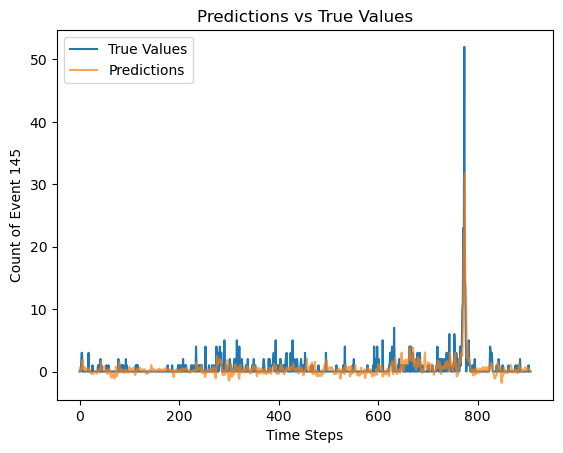

In [24]:
import numpy as np

# Make predictions
predictions = model.predict(test_dataset)

# Visualize predictions vs true values
true_values = np.concatenate([label.numpy() for _, label in test_dataset])
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()
plt.show()

---

Let's focus more on the DNC protests.

---

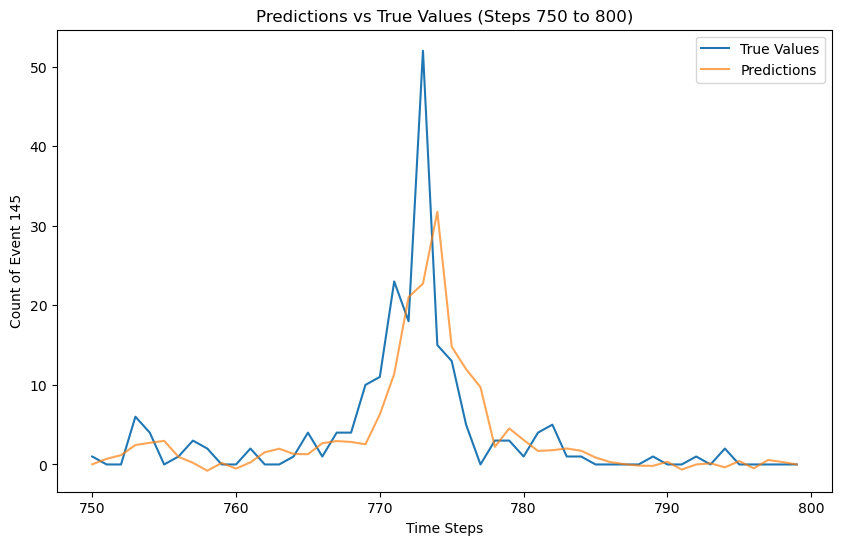

In [27]:
# Define the range for plotting
start_step = 750
end_step = 800

# Extract the relevant range of true values and predictions
true_values_range = true_values[start_step:end_step]
predictions_range = predictions[start_step:end_step]

# Plot the true values and predictions
plt.figure(figsize=(10, 6))
plt.plot(range(start_step, end_step), true_values_range, label='True Values')
plt.plot(range(start_step, end_step), predictions_range, label='Predictions', alpha=0.7)
plt.title('Predictions vs True Values (Steps 750 to 800)')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()
plt.show()

---

## **5. Analyze Results**

### Analyze Performance


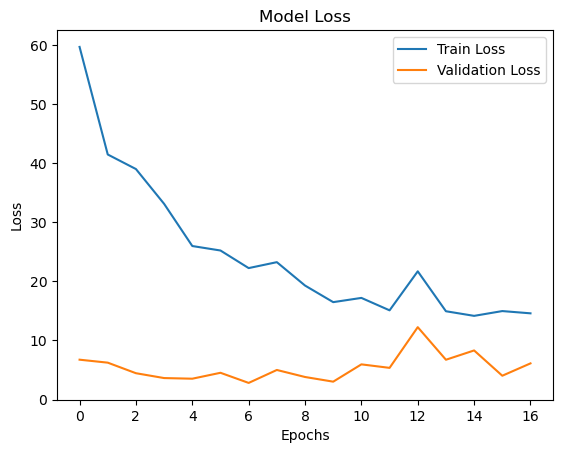

In [25]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

### Observations with Meaning:
1. **Training Loss**: Decreases steadily, meaning the model is learning patterns specific to the training data effectively.
2. **Validation Loss**: Remains flat and low, indicating the model struggles to improve its generalization to unseen data.
3. **Loss Gap**: A noticeable gap exists between training and validation loss, suggesting the model is overfitting to the training data.
4. **Validation Trend**: Validation loss slightly increases toward the end while training loss decreases, confirming overfitting as the model continues to focus on training data at the expense of generalization.



---

## **6. Model Pruning**

### Find Relevant Event Codes


In [26]:

# Identify event codes strongly correlated with '145' events
correlation_matrix = event_count_df.corr()
correlation_with_145 = correlation_matrix[145].sort_values(ascending=False)

print("Event codes most correlated with '145':")
print(correlation_with_145.head(10))

print("Event codes least correlated with '145':")
print(correlation_with_145.tail(10))


Event codes most correlated with '145':
145    1.000000
141    0.604204
175    0.567383
172    0.440217
111    0.398567
133    0.349723
114    0.249185
90     0.207260
144    0.171845
113    0.094943
Name: 145, dtype: float64
Event codes least correlated with '145':
143    0.042906
25     0.032549
123    0.027059
124    0.026916
139    0.022166
104    0.021282
92     0.011899
105    0.001074
94    -0.004944
93    -0.016792
Name: 145, dtype: float64
